# TCN 模型

定义一个扩张卷积模型

In [1]:
import torch
import torch.nn as nn

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

# 这里实际上用的是扩张卷积，能够更好地抓取到长距离地信息
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size
    
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class ConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_sizes, dilation=2, device="cpu", dropout=0):
        super(ConvNet, self).__init__()
        
        layers = []
        for i in range(len(kernel_sizes)):
            dilation_size = dilation ** i
            kernel_size = kernel_sizes[i]
            padding = (kernel_size - 1) * dilation_size
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [
                nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size, padding=padding),
                nn.ReLU(),
                Chomp1d(padding),
                nn.Dropout(dropout)
            ]
        
        # 添加最后一层卷积来预测下一个时间步
        layers += [nn.Conv1d(num_channels[-1], 1, kernel_size=1)]
        self.device = device
        
        self.network = nn.Sequential(*layers)
        self.network.to(device)

    def forward(self, x):
        # 输入 x 的形状为 [batch_size, T, 1]
        x = x.to(self.device)
        x = x.permute(0, 2, 1)  # 变为 [batch_size, 1, T]
        out = self.network(x)  # 通过卷积网络进行前向传播
        out = out[:, :, -1]  # 取最后一个时间步的输出
        return out

基本测试

In [2]:
batch_size = 32
seq_length = 10
num_inputs = 6
num_channels = [16, 32, 64]
kernel_sizes = [2, 2, 2]
device = "cpu"

model = ConvNet(num_inputs, num_channels, kernel_sizes, device=device).to(device)
input_data = torch.randn(batch_size, seq_length, num_inputs).to(device)
print("输入：", input_data.shape)
output = model(input_data)
print("输出：", output.shape)  # 应输出 [batch_size, 1]

输入： torch.Size([32, 10, 6])
输出： torch.Size([32, 1])


## 用TCN做简单的时间序列预测

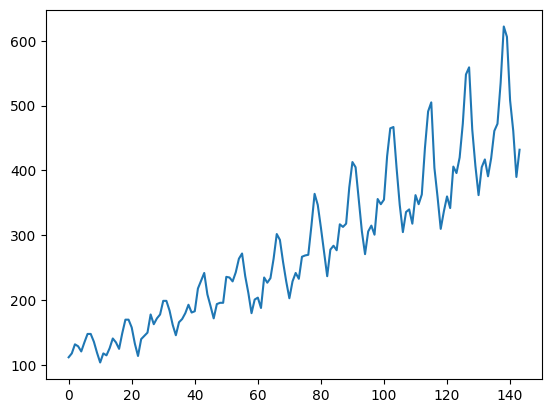

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('./datasets/airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

In [4]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [5]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [6]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1, 1])


C:\Users\jack\AppData\Local\Temp\ipykernel_29536\1294061900.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(X), torch.tensor(y)


In [7]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data


num_inputs = 1
num_channels = [16, 32, 64]
kernel_sizes = [2, 2, 2]
device = "cpu"
model = ConvNet(num_inputs, num_channels, kernel_sizes, device=device).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

c:\Users\jack\anaconda3\envs\d2l\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jack\anaconda3\envs\d2l\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([7, 1, 1])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jack\anaconda3\envs\d2l\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([95, 1, 1])) that is different to the input size (torch.Size([95, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they

Epoch 0: train RMSE 211.7090, test RMSE 393.3495
Epoch 100: train RMSE 96.9749, test RMSE 109.6409
Epoch 200: train RMSE 86.6909, test RMSE 130.0858
Epoch 300: train RMSE 74.0720, test RMSE 162.3233
Epoch 400: train RMSE 72.2627, test RMSE 193.6840
Epoch 500: train RMSE 72.0270, test RMSE 177.6684
Epoch 600: train RMSE 71.7722, test RMSE 189.3394
Epoch 700: train RMSE 71.8337, test RMSE 187.7404
Epoch 800: train RMSE 71.7118, test RMSE 184.5312
Epoch 900: train RMSE 73.2767, test RMSE 167.2641
Epoch 1000: train RMSE 71.8177, test RMSE 184.2659
Epoch 1100: train RMSE 71.8014, test RMSE 186.1412
Epoch 1200: train RMSE 71.8573, test RMSE 189.9583
Epoch 1300: train RMSE 71.6776, test RMSE 184.5759
Epoch 1400: train RMSE 73.6023, test RMSE 168.0099
Epoch 1500: train RMSE 71.9435, test RMSE 179.9916
Epoch 1600: train RMSE 72.1048, test RMSE 174.6153
Epoch 1700: train RMSE 71.7773, test RMSE 185.2665
Epoch 1800: train RMSE 71.7559, test RMSE 190.3502
Epoch 1900: train RMSE 72.0786, test RMSE 

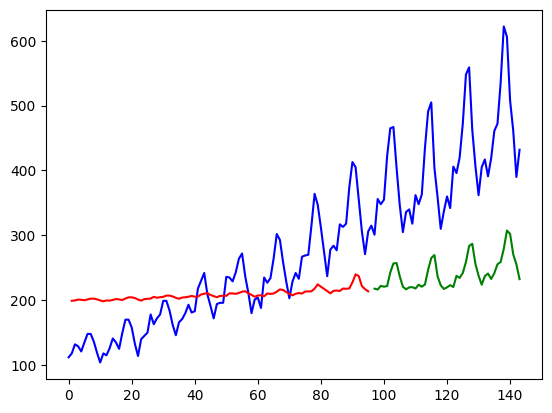

In [9]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1]
    train_plot[lookback:train_size] = model(X_train)[:, -1].reshape(-1,1).cpu().numpy()
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1].reshape(-1,1)
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()